In [2]:
#Imports
import numpy as np
import pandas as pd
import os
from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [68]:
#Getting the list of files
dirpath = os.path.dirname(os.getcwd())
datapath = os.path.join(dirpath, 'data/ML')
list_files = listdir_nohidden(datapath)
suffix = [files.split('.')[3] for files in list_files]
#Starter code when we want to use different bands for analysis
file_s = list_files[0]
print file_s

lc_1.3324.122.B.mjd


In [69]:
filepath = os.path.join(datapath, file_s)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [str(val) for val in lines[2].split(' ')]
    for line in lines[3:]:
        data.append([float(val) for val in line.split(' ')])

In [70]:
data_df = pd.DataFrame(data)
data_df.columns = header

/Users/abhishek/CSE/thesis-work/astro-sn/graphs/microlensy/lc_1.3324.122.B.mjd.png


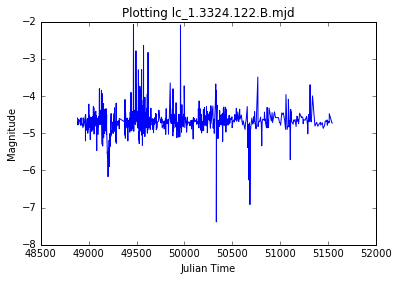

In [76]:
plt.plot(data_df['#MJD'], data_df['Mag'])
plt.xlabel('Julian Time')
plt.ylabel('Magnitude')
plt.title('Plotting '+file_s)
plt.savefigos.path.join(dirpath,'graphs/microlensy/')\
            +file_s+'.png'